In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from glob import glob
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
#Mount your google drive
from google.colab import drive
drive.mount('/content/gdrive/')

In [3]:
## PLEASE MODIFY THIS ##

#Train Method
class ResidualUnit(keras.layers.Layer): #subclass of keras.layers.Layer
    def __init__(self, filters, strides = 1, activation = 'relu', **kwargs) -> None: #constructor
        super().__init__(**kwargs)#starting of constructor
        self.activation = keras.activations.get(activation)# initializing
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides = strides, padding = 'same', use_bias = False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides = 1, padding = 'same', use_bias = False),
            keras.layers.BatchNormalization()]
        """It was main type line, defing working scheme"""
        self.skip_layers = []
        if strides > 1:#additional convolutional and batch normalization layers are added to the skip_layers list.
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides = strides, padding = 'same', use_bias = False),
                keras.layers.BatchNormalization()]
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:#inputs propagated in main layers
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers: # adding short cut
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)#output of ResidualUnit
"""
How inputs are propagated
"""

#Upload train dataset
train_dataset_path = '/content/gdrive/MyDrive/train.npy'
test_dataset_path =  '/content/gdrive/MyDrive/test.npy'
#You can refer the tutorial ppt if you want to know more details about this

valid_ratio = 0.2 # Type the ratio for splition train data into train and valid.
batch_size = 64 #number of batches refers to the division of the training dataset into subsets
n_epoch = 100 #the number of epochs represents the number of times the model iterates
                #over the entire training dataset during training

In [ ]:
train_np_data = np.load(train_dataset_path, allow_pickle=True) #Upload train data. train_np_data consists of img(data) and label(target).
data, target = np.asarray(train_np_data.item().get('data')), np.asarray(train_np_data.item().get('target')) #Get img data(data) and label(target) from train_np_data.

#Explore the dataset
print(f"total number of img data : {data.shape[0]}")
print(f"total number of label data : {target.shape[0]}")

sample_data, sample_target = data[0], target[0]
print(sample_data.shape) # (160, 160, 3) --> img size is 160 x 160 and its type is RGB image(3 channel).
print(sample_target.shape) # (15, ) --> one-hot encoding for label. /// ex)  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] --> the solution label is the 4th label.

X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size = valid_ratio) # Split train data into train and valid according to the split ratio.
print(X_train.shape, y_train.shape)

Action : calling


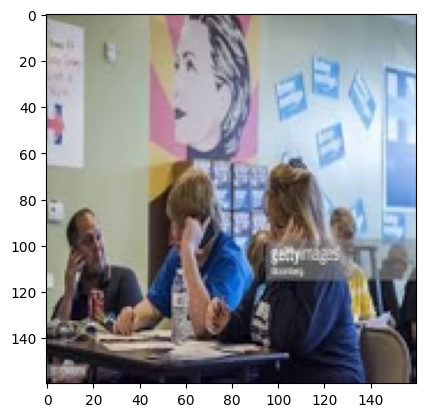

In [ ]:
#Visualize the image sample
%matplotlib inline

action_dict = {'0': 'sitting', '1': 'sleeping', '2': 'running', '3': 'cycling', '4': 'texting', '5': 'calling', '6': 'eating',
         '7': 'clapping', '8': 'drinking', '9': 'hugging', '10': 'using_laptop', '11': 'laughing',
               '12': 'listening_to_music', '13': 'fighting' , '14': 'dancing'} # Dictionary used for converting one-hot encoding to genre name.

img_order = 500 # You can select any image you want by changing the variable 'img_order'.
sample_data = data[img_order] #Get the image in data.
sample_data = sample_data.astype(int)
sample_target = target[img_order] #Get the target about the selected image. it is the state of one-hot encoding.
sample_action = action_dict[str(np.argmax(sample_target))] #Convert one-hot encoding to genre name

print(f"Action : {sample_action}")
plt.imshow(sample_data)

In [ ]:
STEP_SIZE_TRAIN = X_train.shape[0]//batch_size
STEP_SIZE_VALID = X_valid.shape[0]//batch_size

print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Total number of batches = 75 and 18


In [ ]:
model = keras.models.Sequential()#making sequential architecture

model.add(keras.layers.Conv2D(64, 7, strides = 2, input_shape = [160, 160, 3], padding = 'same', use_bias = False))#adding convolutional layers,
                                                #64 is a number of filters or channels, 7x7 is a size of conv. kernel or filter, 2 is a stride(step size),
                                                #[160, 160, 3] is an input shape, 'same' is a padding strategy that inputs padded with zeros,
                                                #and not including bias
model.add(keras.layers.BatchNormalization())#add a Batch Normalization layer to a keras model
model.add(keras.layers.Activation('relu'))#adds a relu activation function layer after the previous layer in the model
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same'))#add a MaxPooling layer after the previous layer in the model.
                                          #polling window is 3x3, and  pooling window will move 2 pixels at a time,'same' is a padding strategy.
"""Then we stack ResidualUnit on model, a series of residual units with
increasing numbers of filters are added to the model, with the stride value
set to 1 if the number of filters is the same as the previous layer, and 2 otherwise."""
prev_filters = 64
"""This code iteratively adds residual units to the model, where the number of
filters increases in specific patterns ([64] * 3, [128] * 4, [256] * 6, [512] * 3)"""
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides)) # adding residual units to the model
    prev_filters = filters

model.add(keras.layers.GlobalAvgPool2D())#applying a global average pooling layer to the model,
                                        #which computes the average value for each channel of the input feature maps
model.add(keras.layers.Flatten())#adds a flatten layer that reshapes the input into a one-dimensional vector
model.add(keras.layers.Dense(15, activation = 'softmax'))#adds a fully connected dense layer with 15 units and a softmax activation function

width_shift = 3/32

height_shift = 3/32

flip = True

datagen = ImageDataGenerator(
    width_shift_range = width_shift,
    height_shift_range = height_shift,
    horizontal_flip = flip
)
datagen.fit(X_train)#The ImageDataGenerator is fitted to the training data X_train

train_datagen = ImageDataGenerator(width_shift_range = width_shift, height_shift_range = height_shift, horizontal_flip = flip)#train_datagen is configured
                            #with augmentation settings such as width_shift_range, height_shift_range, and horizontal_flip, which introduce random shifts
                            #and horizontal flipping to the training images.
valid_datagen = ImageDataGenerator(rescale = 1)#valid_datagen is configured with rescale = 1, which performs rescaling
                                              #of the validation images without any additional augmentation.

#These generators will yield batches of augmented training and validation data, respectively, with a batch size of 32
train_generator = train_datagen.flow(X_train, y_train, batch_size = 32)
valid_generator = train_datagen.flow(X_valid, y_valid, batch_size = 32)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [ ]:
# Compile your model
model.compile(optimizer = 'nadam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 80, 80, 64)        9408      
                                                                 
 batch_normalization (BatchN  (None, 80, 80, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 80, 80, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 40, 64)       0         
 )                                                               
                                                                 
 residual_unit (ResidualUnit  (None, 20, 20, 64)       78592     
 )                                                               
                                                        

In [ ]:
# Training
history = model.fit(train_generator, epochs = n_epoch, batch_size=batch_size,
                    validation_data = valid_generator, callbacks = [callback])
"""
The model.fit() function starts the training process, iterating over the specified
number of epochs and updating the model's weights based on the training data.
validation_data = valid_generator: This specifies the generator for the validation data.
train_generator: This is the generator that yields batches of augmented training data.
The model will be trained on these batches in each epoch.
"""

Epoch 1/100
150/150 [==============================] - 39s 257ms/step - loss: 0.0573 - accuracy: 0.9829 - val_loss: 4.1358 - val_accuracy: 0.4333
Epoch 2/100
150/150 [==============================] - 44s 291ms/step - loss: 0.0375 - accuracy: 0.9877 - val_loss: 3.7275 - val_accuracy: 0.4450
Epoch 3/100
150/150 [==============================] - 39s 263ms/step - loss: 0.0431 - accuracy: 0.9862 - val_loss: 3.8944 - val_accuracy: 0.4275
Epoch 4/100
150/150 [==============================] - 42s 280ms/step - loss: 0.0608 - accuracy: 0.9829 - val_loss: 4.1322 - val_accuracy: 0.4117
Epoch 5/100
150/150 [==============================] - 41s 276ms/step - loss: 0.0515 - accuracy: 0.9842 - val_loss: 3.6279 - val_accuracy: 0.4575
Epoch 6/100
150/150 [==============================] - 42s 280ms/step - loss: 0.0418 - accuracy: 0.9862 - val_loss: 4.9382 - val_accuracy: 0.3700
Epoch 7/100
150/150 [==============================] - 39s 263ms/step - loss: 0.0475 - accuracy: 0.9848 - val_loss: 4.2865 -

In [ ]:
### Test method ###

test_np_data = np.load(test_dataset_path, allow_pickle=True) #Upload test data. test_np_data consists of img(data) and img name(name).
data, name = np.asarray(test_np_data.item().get('data')), np.asarray(test_np_data.item().get('name')) ##Get img data(data) and name from test_np_data.
#name will be used for creating result.csv file. So, Consider only data.

#Explore the dataset
print(f"total number of img data : {data.shape[0]}")
print(f"shape of img : {data.shape[1:]}")

total number of img data : 1000
shape of img : (160, 160, 3)


In [ ]:
# Example of model prediction
output = model.predict(data) #Predict the result with your trained model.
output = np.argmax(output, axis = -1) #Convert one-hot encoding to label
print(output)

32/32 [==============================] - 1s 20ms/step
[14 10  3  1  9  9 12  9  8  1 12  3 14  2 11  5 14  8 11  6 13  3  6  9
 10  5 14  2  4  6  5  3  9  5 10  6  6  9  4  7  2  3  8 10  9 12 11 11
  8  7 11  6  6 14  2 13 10  1  8  2  9 12  5  2 12 14  8 10  4 14  6  4
 13  6  5  3  9  9 11  8  6  3  4  3  5  5  7  0  2  6 10  1  3 10  8  8
 11 14  2 14  1 12  7  8 10  9 11  0 11  6 10 14 13  8  0 14  5 10 10  8
 11  2  1  3  3  8  4  8 14  3 13  8  3  1  3  3 11 14  8  9 13 13  7  2
  8  9  9  3 13  7  1  3  6  6  3 11  9  7  6 10  2 12 10  6  6  8  2 14
  6 13 14  8  9 13 11  5 13  3  1  1  8  2  1  6 14 10  6 10  6  2 11  6
 11  5 12 12 10 10 10  5  9  8 14 11  5  9  9  2  3  7  4 14  6  2  6 13
  7  7  6 10  1  1  4 10  0  3  4  2  8 11 13  7  9  1  5 13  8  2  1  6
  2  6  9  1  5 11  7  5 14  2 12  6 12 11  3  1  2  3  5 13  4 14 14  5
 13  6 11  3  0  8  1  8 14  9 12  9 12  8  9  9 12  8 14 11  9  1 12  8
  1 12 13  5  4  5  0  3  2  4 11 10  5  8 14 10  0 12 14  5  8  8 12 

In [ ]:
# Save your result to csv file.
data = {
    'img' : name,
    'predictions' : output
}

# You should  submit the saved `result.csv' to the codalab.

def _key(_str): #extract the order from img_name
  # print(_str)
  str2int = int(_str.split('_')[1].split('.')[0])
  return str2int

output_df = pd.DataFrame(data) # Create dataframe
output_df['order'] = output_df['img'].apply(_key) #the 'order' column is used for sorting output in descending order.
output_df = output_df.sort_values(by = 'order')
output_df = output_df[['img', 'predictions']].reset_index(drop = True) #Extract colunms necessary to evaluate in Codalab.

output_df.to_csv('result.csv')